# Predicting Heart Disease

The World Health Organization (WHO) estimates that 17.9 million people die every year because of cardiovascular diseases (CVDs).

There are multiple risk factors that could contribute to CVD in an individual such as unhealthy diet, lack of physical activity or mental illnesses. Being able to identify these risk factors in individuals early on could help prevent a lot of premature deaths.

In this project, we will use a [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) and build a K-Nearest Neighbors classifier to accurately predict the likelihood of a patient having a heart disease in the future. 

In [1]:
# import libraries
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## EDA: Descriptive Statistics

We will start with exploring our dataset. As per the source, each patient has the following information collected about them:


1. `Age`: age of the patient [years]
2. `Sex`: sex of the patient [M: Male, F: Female]
3. `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. `RestingBP`: resting blood pressure [mm Hg]
5. `Cholesterol`: serum cholesterol [mm/dl]
6. `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
9. `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
10. `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
11. `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. `HeartDisease`: output class [1: heart disease, 0: Normal]

In [2]:
#load dataset
df = pd.read_csv("heart_disease_prediction.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


The dataset contains both numerical and categorical features. Let's look at the data type of each column:

In [3]:
print(df.dtypes)
df.dtypes.value_counts()

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


int64      6
object     5
float64    1
Name: count, dtype: int64

I notice that FastingBS and HeartDisease both have the dtype int64 but can only take the binary values 1 and 0, making them categorical features. This means that in total we have 5 numerical columns and 7 categorical columns, which we will have to transform in some way.

In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


From the above cell, I extracted the following key insights:
- The dataset contains data of patients between 28 and 77 years of age.

- The median for Cholesterol is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.

- RestingBP & Cholesterol have a minimum value of 0, which isn't possible and will need to be cleaned later.

In [5]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There aren't any missing values in the dataset!

## EDA: Data Visualisations
We identified that the categorical features are mostly of dtype object:

In [6]:
df.describe(include=['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [7]:
df["FastingBS"].unique(), df["HeartDisease"].unique() 

(array([0, 1]), array([0, 1]))

The small number of unique features confirm that these columns are indeed categorical. It is difficult to extract further details about these features - creating some plots might help.

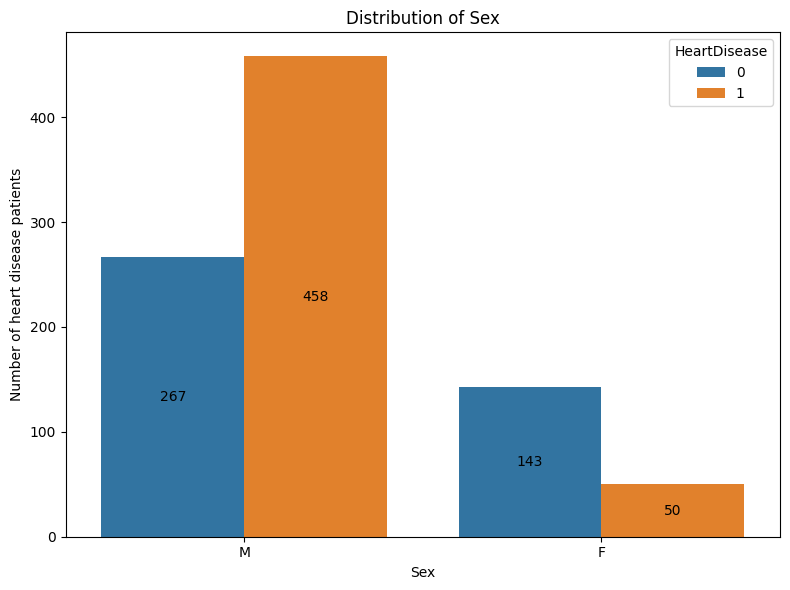

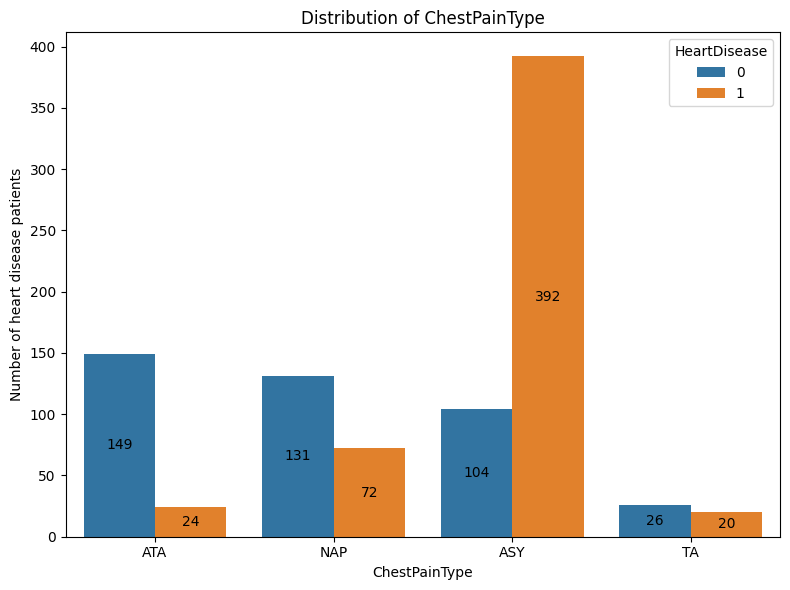

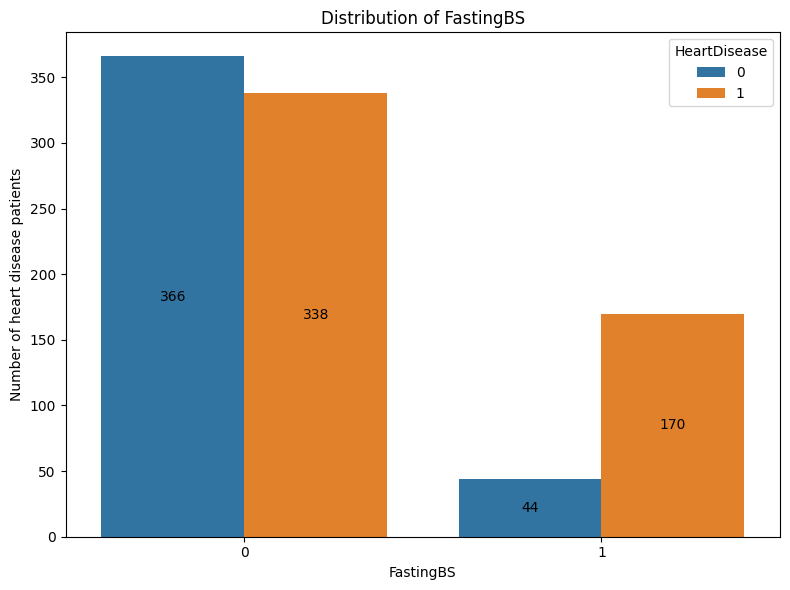

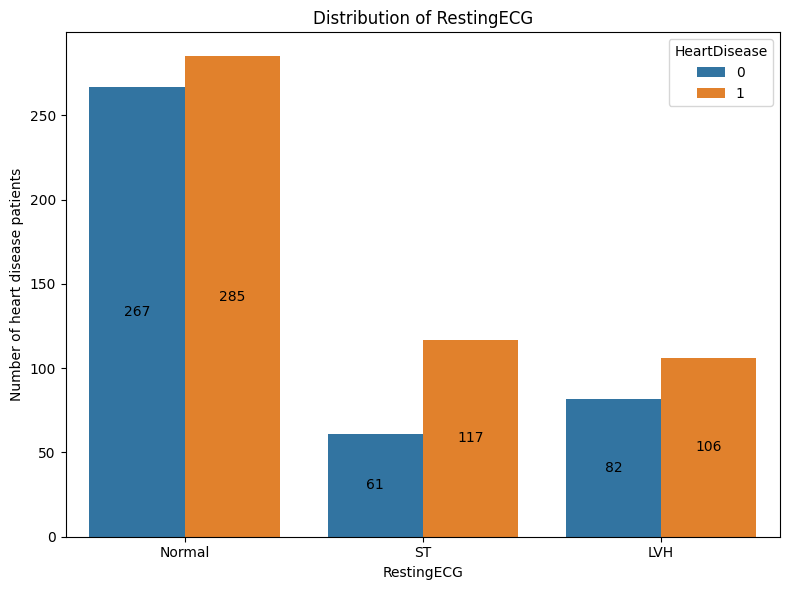

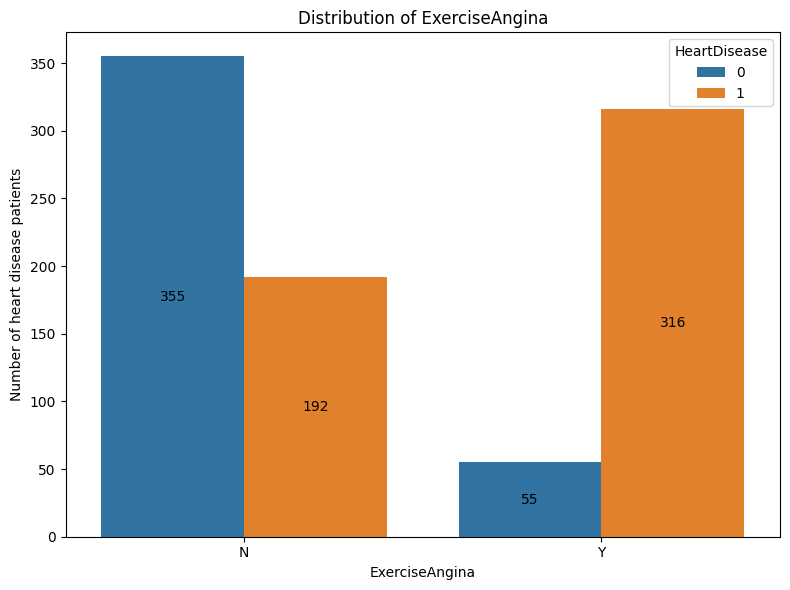

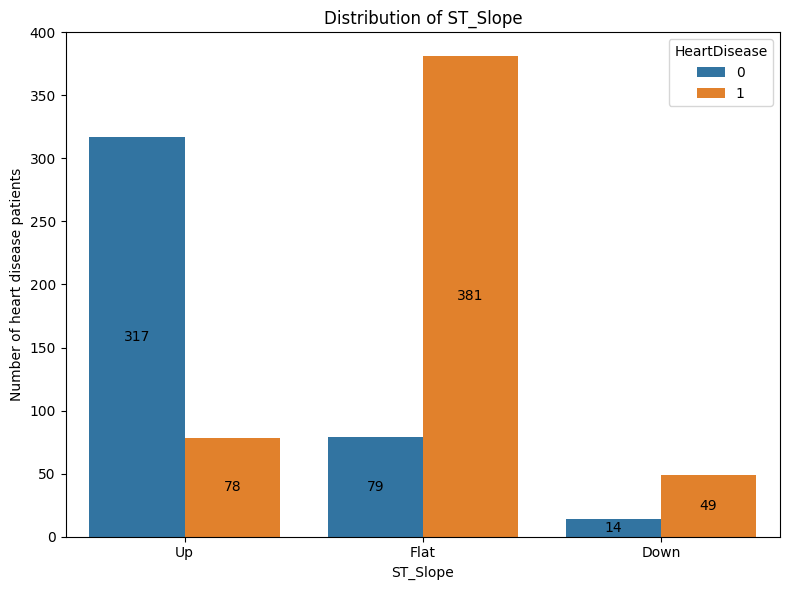

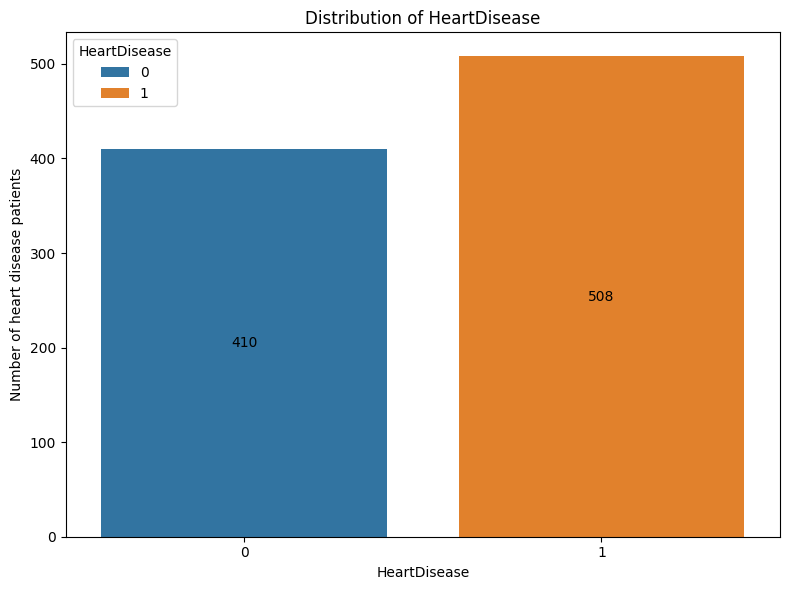

In [8]:
cat_cols = [cname for cname in df.columns if df[cname].dtypes == "object" or cname == "HeartDisease" or cname == "FastingBS"]

for col in cat_cols:
    plt.figure(figsize=(8, 6))  # Create new figure for each plot
    
    # Create the plot first
    ax = sns.countplot(data=df, x=col, hue="HeartDisease")
    
    # Then set labels and title
    plt.xlabel(col)
    plt.ylabel("Number of heart disease patients")
    plt.title(f"Distribution of {col}")
    
    for container in ax.containers:
        ax.bar_label(container, label_type = "center")
    
    # Display the plot
    plt.tight_layout()
    plt.show()

- The dataset is highly skewed towards male patients. There are 725 male patients and 193 female patients with only `50` females being diagnosed with heart disease. This could potentially induce a bias in our model.
- A significant number of patients, `392`, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom. 
- A high number (`170`) of patients with blood sugar greater than `120` mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.
- Out of all patients who had an exercise-induced angina, `85%` were diagnosed with a heart disease.
- Out of all patients with a flat ST slope, `83%` were diagnosed with a heart disease.

Looking at the data distribution from the above plots, we can start to identify some features that could be relevant to us. We will clean up the dataset a bit first before narrowing down on our features.

## Data Cleaning

We identified that there are no missing values. However, as we noticed earlier, a couple of columns have 0 values which don't make sense.

We will look at how many zero values `RestingBP` and `Cholesterol` contain and decide how to handle those.

In [9]:
df[df["RestingBP"]==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


Since there's only one invalid row, it is safe to just drop this row without significantly impacting our model:

In [10]:
df_clean = df.copy() # dataset after cleaning
df_clean = df[df["RestingBP"]!=0]

In [11]:
df[df["Cholesterol"]==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


There are 172 rows with an invalid cholesterol value. Since this is a large proportion of the dataset (~18.7%), it is better to impute these rows. I will replace the invalid values with the median value of the corresponding column and the corresponding HeartDisease value:

In [12]:
df_clean["Cholesterol"] = df_clean.groupby("HeartDisease")["Cholesterol"].transform(
    lambda x: x.mask(x == 0, x.median())
)

/tmp/ipykernel_44/3164468512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Cholesterol"] = df_clean.groupby("HeartDisease")["Cholesterol"].transform(


Check to see if data cleaning was successful:

In [13]:
(df_clean==0).sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol         0
FastingBS         703
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak           368
ST_Slope            0
HeartDisease      410
dtype: int64

In [14]:
df_clean["Cholesterol"].describe()

count    917.000000
mean     239.700109
std       54.352727
min       85.000000
25%      214.000000
50%      225.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

In [15]:
df_clean["RestingBP"].describe()

count    917.000000
mean     132.540894
std       17.999749
min       80.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64

The minimum values for both have changed! There are no more zero values in either of them.

## Feature Selection

Thanks to our EDA and a general understanding of the features, we can identify some of the features that we could start with:

- `Age`
- `Sex`
- `ChestPainType`
- `Cholesterol`
- `FastingBS`


We will also identify how stronly the feature columns are correlated to the target colummn. That should help us narrow down on the features.

In order to do that, we will first convert our categorical columns into dummy variables.

In [16]:
df_clean = pd.get_dummies(df_clean, drop_first=True)
df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


<Axes: title={'center': 'Correlation between features & heart disease'}>

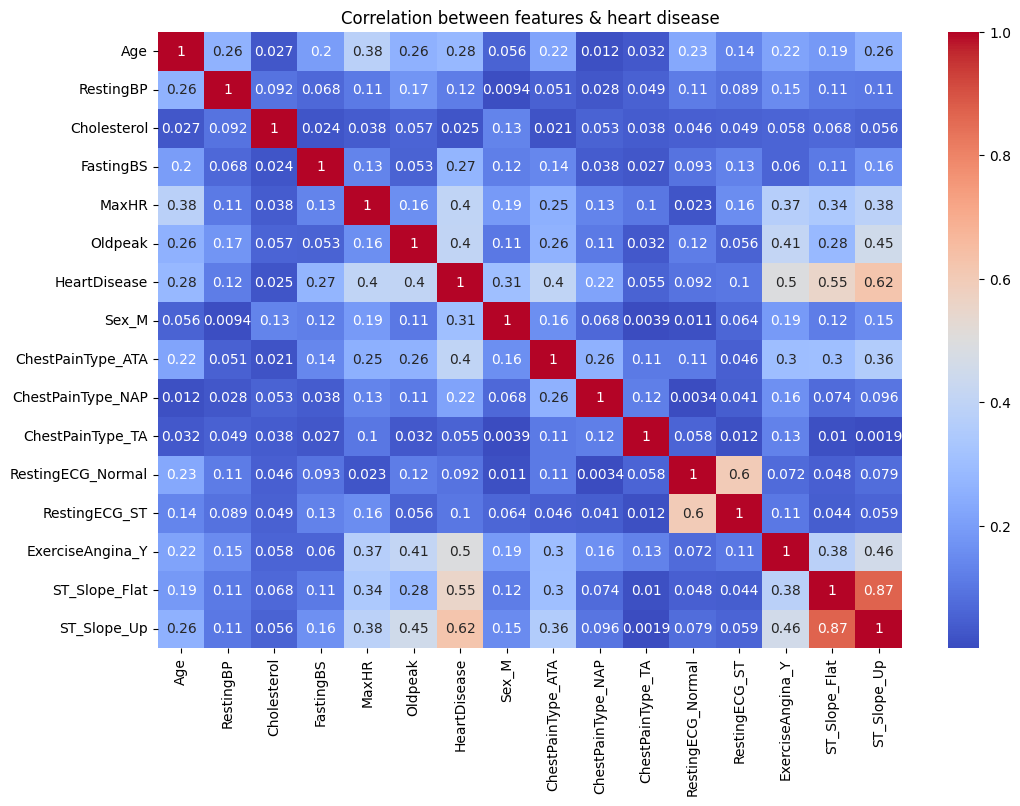

In [17]:
correlations = abs(df_clean.corr())
plt.figure(figsize=(12,8))
plt.title("Correlation between features & heart disease")
sns.heatmap(data=correlations,annot=True,cmap="coolwarm")

- ST_Slope_Up has the strongest positive correlation with heart disease out of all the features.
- Cholesterol ST_Slope_Up has the weakest correlation with heart disease out of all the features.
- ST_Slope_Up and ST_Slope_Flat have a very high correlation with each other - I will need to experiment to see if using both harms my model due to multicollinearity.

<Axes: >

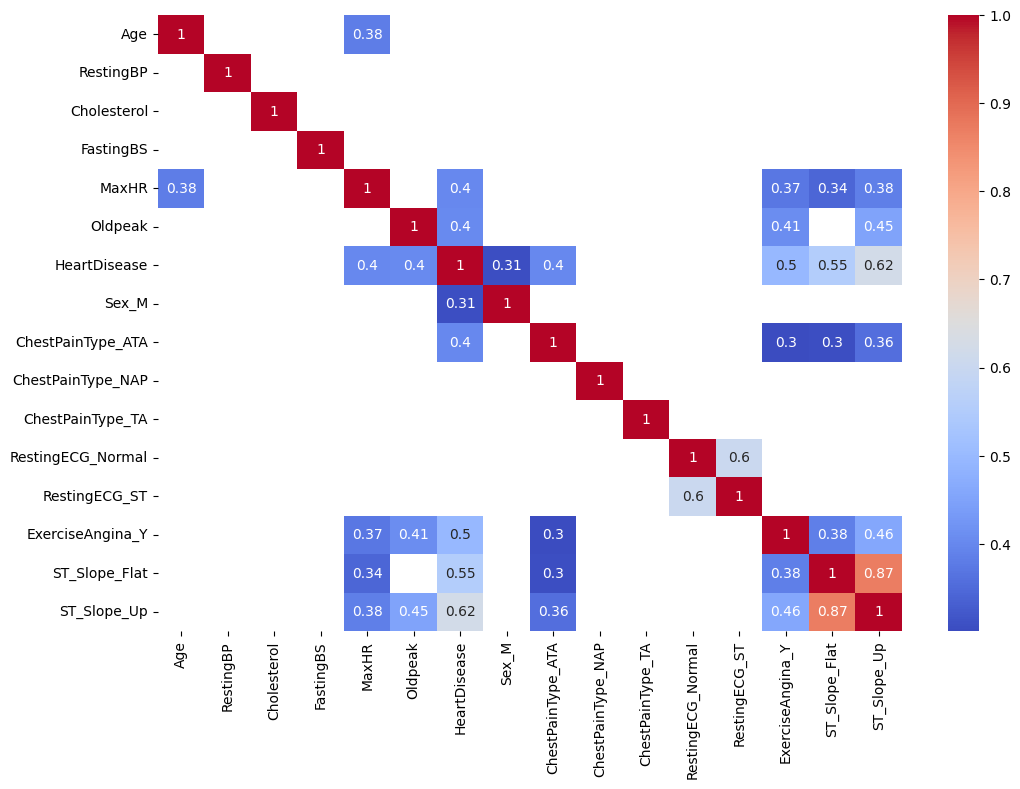

In [18]:
plt.figure(figsize=(12,8))
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap="coolwarm")

From our correlation heatmap, we can identify the following features to be positively correlated (correlation coefficient greater than 0.3) to `HeartDisease`:
- MaxHR
- Oldpeak
- Sex_M
- ChestPainType_ATA
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_Up

However, this doesn't mean the other features are useless. Correlation only measures linear relationships. A feature might have a strong non-linear relationship with the target but show weak linear correlation. Also, a feature might be weak alone but powerful when combined with others. I will use mutual information in the following function to determine which features are like this.

In [19]:
X = df_clean.drop(["HeartDisease"],axis=1)
y = df_clean["HeartDisease"]

def analyze_mutual_information(X, y,feature_names=X.columns):
    print("=== MUTUAL INFORMATION ANALYSIS ===")
    print("(Higher values = stronger relationship, including non-linear)")
    
    # Calculate mutual information
    mi_scores = mutual_info_classif(X, y, random_state=42)
    
    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(X.shape[1])]
    
    # Create DataFrame for easy viewing
    mi_df = pd.DataFrame({
        'Feature': feature_names,
        'Mutual_Information': mi_scores
    }).sort_values('Mutual_Information', ascending=False)
    
    # Visualise
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(mi_scores)), mi_df['Mutual_Information'])
    plt.title('Mutual Information Scores (Higher = More Informative)')
    plt.xlabel('Features')
    plt.ylabel('Mutual Information')
    plt.xticks(range(len(mi_scores)), mi_df['Feature'], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return mi_df

=== MUTUAL INFORMATION ANALYSIS ===
(Higher values = stronger relationship, including non-linear)


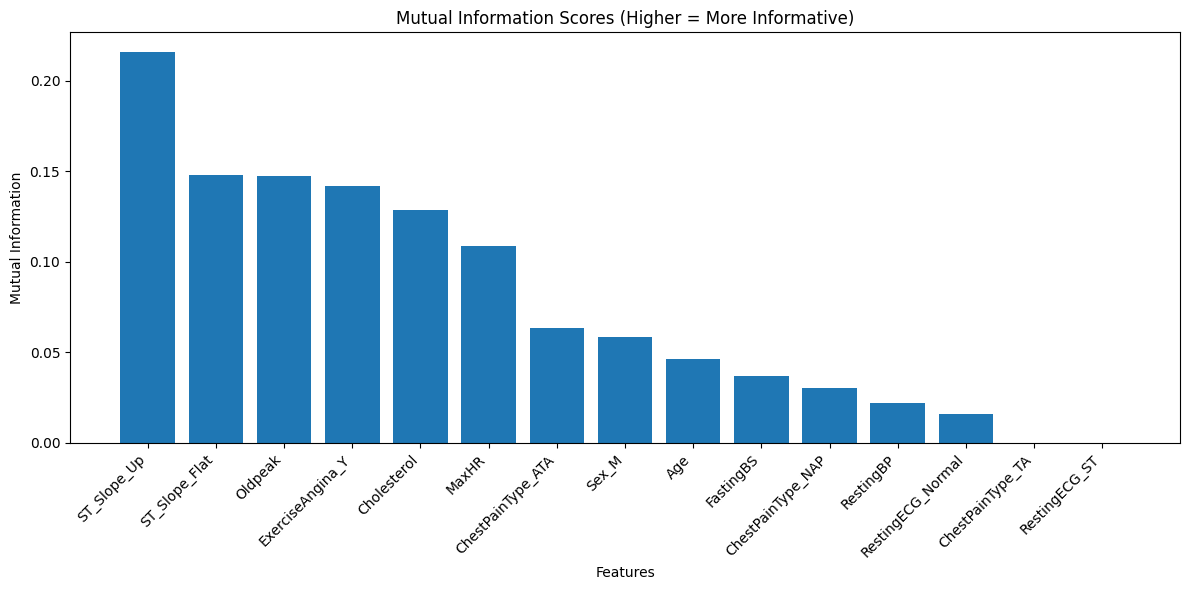

,Feature,Mutual_Information
14,ST_Slope_Up,0.215803
13,ST_Slope_Flat,0.147615
5,Oldpeak,0.147505
12,ExerciseAngina_Y,0.141896
2,Cholesterol,0.128765
4,MaxHR,0.108893
7,ChestPainType_ATA,0.063410
6,Sex_M,0.058591
0,Age,0.046441
3,FastingBS,0.036946


In [20]:
analyze_mutual_information(X, y)

Given everything we have attempted so far, we can narrow down our features to the following:

- `Oldpeak` (high correlation coefficient & MI)
- `Sex_M` (low value for correlation coefficient & MI , but given what we observed in our EDA, let's also take it into account)
- `ExerciseAngina_Y` (high correlation coefficient & MI)
- `ST_Slope_Up` (high correlation coefficient & MI)
- `Cholesterol` (high MI & known risk factor for heart disease)
- `MaxHR` (high correlation coefficient & MI)
- `ST_Slope_Flat` (high correlation coefficient & MI)

Time to create our model using these features!

## Building a Classifier

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.18,random_state=42)
features = ["Oldpeak",
            "Sex_M",
            "ExerciseAngina_Y",
            "ST_Slope_Up",
            "Cholesterol",
            "MaxHR",
            "ST_Slope_Flat"
           ]

We will start with creating a model for each of the features above and evaluate their performance using accuracy as a metric.

In [22]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 5, weights="distance")
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 5 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on Oldpeak and with k = 5 has an accuracy of 61.45%
The k-NN classifier trained on Sex_M and with k = 5 has an accuracy of 68.07%
The k-NN classifier trained on ExerciseAngina_Y and with k = 5 has an accuracy of 60.84%
The k-NN classifier trained on ST_Slope_Up and with k = 5 has an accuracy of 80.12%
The k-NN classifier trained on Cholesterol and with k = 5 has an accuracy of 62.05%
The k-NN classifier trained on MaxHR and with k = 5 has an accuracy of 63.86%
The k-NN classifier trained on ST_Slope_Flat and with k = 5 has an accuracy of 60.84%


Our best performing model was the one trained on ST_Slope_Up with an accuracy score of ~ 80%. This makes sense given its correlation coefficient and mutual information results. 

We will train a model using all of these features next.

## Building a Classifier with Multiple Features

Before training on all of the above features, we need to normalise the data first. We will use scikit-learn's MinMaxScaler to scale the values between 0 and 1, and then train the model again.

In [23]:
scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

X_train_scaled[features] = scaler.fit_transform(X_train[features])
X_val_scaled[features] = scaler.transform(X_val[features])

#test to see if scaler worked (all values should be between 0 and 1)
X_train_scaled["Sex_M"].describe()

count    751.000000
mean       0.782956
std        0.412508
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Sex_M, dtype: float64

Now we can train a model with all the scaled numerical features:

In [24]:
knn_scaled = KNeighborsClassifier(n_neighbors = 5, weights="distance")
knn_scaled.fit(X_train_scaled[features], y_train)
accuracy = knn_scaled.score(X_val_scaled[features], y_val)
print(f"The KNN classifier trained on all the selected features and with k = 5 has an accuracy of {accuracy*100:.2f}%") 

The KNN classifier trained on all the selected features and with k = 5 has an accuracy of 84.34%


The model's accuracy jumped to ~ 84%! That's not a significant improvement, but still a good start. Using all the features together results in an improved model. Now let's see what parameters/hyperparameters might be optimal.

## Hyperparameter Optimisation

Let's prepare our data first.

In [25]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state = 42)

features = ["Oldpeak",
            "Sex_M",
            "ExerciseAngina_Y",
            "ST_Slope_Up",
            "Cholesterol",
            "MaxHR",
            "ST_Slope_Flat"
           ]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

In [26]:
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan", "euclidean"],
                "weights": ["uniform", "distance"],
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': range(1, 20),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [27]:
knn_grid.best_score_*100, knn_grid.best_params_

(np.float64(84.68256070640177),
 {'metric': 'minkowski', 'n_neighbors': 19, 'weights': 'uniform'})

Optimising the parameters lead to a small increase in accuracy to ~ 85%. Since `GridSearchCV` employs a cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt. The results of the grid search show the optimal values for each parameter:
- `metric`: minkowski
- `n_neighbors`: 19
- `weights`: uniform

We will evaluate our model on our test set now.

## Model Evaluation on Test Set

We need to first normalise our test set similar to how we scaled our training set.

In [33]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 80.72


## Summary and Next Steps

The final accuracy for our model is ~ 81%! This is about 4% lower than the training accuracy, showing that a good generalisation has been made and little underfitting/overfitting has occured. With regards to using the model in a practical setting, it should only be used as a supportive screening with mandatory physician review rather than as a standalone diagnostic system. This is because the model is incorrect in almost 1 in 5 cases. A false positive could delay treatment and be potentially fatal, whilst a false negative could cause unnecessary anxiety and waste resources (money, tests, hospital beds etc.). Even if it slightly reduces overall accuracy, it may be worthwhile to improve sensitivity (catching actual heart disease cases) to avoid false negatives. 

To further improve the model, I could:
- Try out a different combination of features.
- Expand the grid search parameters to identify more optimal hyperparameters.
- Explore other algorithms that might perform better than k-NN e.g XGBoost.
- Try and collect more data.